In [1]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Step 2: Navigate to the zip file
import os
zip_path = '/content/drive/MyDrive/archive (2).zip'  # Replace with your actual path

In [3]:
# Verify the sub files
extracted_path_2 = '/content/drive/MyDrive/Attendance/Cropped Faces'
extracted_files_2 = os.listdir(extracted_path_2)
print(extracted_files_2)

['Angelina Jolie', 'Brad Pitt', 'Denzel Washington', 'Hugh Jackman', 'Jennifer Lawrence', 'Johnny Depp', 'Kate Winslet', 'Leonardo DiCaprio', 'Megan Fox', 'Natalie Portman', 'Nicole Kidman', 'Robert Downey Jr', 'Sandra Bullock', 'Scarlett Johansson', 'Tom Cruise', 'Tom Hanks', 'Will Smith']


In [4]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from collections import Counter

In [5]:
croppedPath = '/content/drive/MyDrive/Attendance/Cropped Faces'

In [6]:
# Preprocess images
def preprocess_image(image_path, target_size=(160, 160)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size)
    image = image.astype('float') / 255.0
    image = img_to_array(image)
    return image

In [7]:
def preprocess_dataset(dataset_path, target_size=(160, 160)):
    data = []
    labels = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png')):
                image_path = os.path.join(root, file)
                image = preprocess_image(image_path, target_size)
                label = root.split(os.path.sep)[-1]
                data.append(image)
                labels.append(label)
    return np.array(data), np.array(labels)

In [8]:
data, labels = preprocess_dataset(croppedPath)

In [9]:
def get_dataset_statistics(dataset_path):
    image_count = 0
    class_counter = Counter()
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png')):
                image_count += 1
                class_label = root.split(os.path.sep)[-1]
                class_counter[class_label] += 1

    total_classes = len(class_counter)
    return image_count, total_classes, class_counter

# Path to the extracted dataset
dataset_path = '/content/drive/MyDrive/Attendance/Cropped Faces'

# Get dataset statistics
total_images, total_classes, class_distribution = get_dataset_statistics(dataset_path)

# Print dataset statistics
print(f'Total number of images: {total_images}')
print(f'Total number of unique classes: {total_classes}')
print(f'Class distribution: {class_distribution}')


Total number of images: 1629
Total number of unique classes: 17
Class distribution: Counter({'Natalie Portman': 100, 'Leonardo DiCaprio': 99, 'Nicole Kidman': 99, 'Scarlett Johansson': 99, 'Jennifer Lawrence': 98, 'Angelina Jolie': 97, 'Brad Pitt': 97, 'Hugh Jackman': 97, 'Tom Hanks': 97, 'Megan Fox': 96, 'Robert Downey Jr': 95, 'Sandra Bullock': 95, 'Tom Cruise': 95, 'Denzel Washington': 94, 'Johnny Depp': 93, 'Kate Winslet': 93, 'Will Smith': 85})


In [10]:
# Debug: Check unique labels and their count
unique_labels = np.unique(labels)
print(f'Unique labels before encoding: {unique_labels}')
print(f'Number of unique labels: {len(unique_labels)}')

Unique labels before encoding: ['Angelina Jolie' 'Brad Pitt' 'Denzel Washington' 'Hugh Jackman'
 'Jennifer Lawrence' 'Johnny Depp' 'Kate Winslet' 'Leonardo DiCaprio'
 'Megan Fox' 'Natalie Portman' 'Nicole Kidman' 'Robert Downey Jr'
 'Sandra Bullock' 'Scarlett Johansson' 'Tom Cruise' 'Tom Hanks'
 'Will Smith']
Number of unique labels: 17


In [11]:
# Determine the number of classes
num_classes = len(unique_labels)
print(f'Number of classes: {num_classes}')

Number of classes: 17


In [12]:
# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [13]:
# Save the fitted LabelEncoder for later use
import pickle
with open('/content/drive/MyDrive/Attendance/label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

In [14]:
# Convert labels to one-hot encoding
labels = to_categorical(labels, num_classes=num_classes)

In [15]:
# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16,EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
from tensorflow.keras.models import load_model

# Load the fine-tuned model from Google Drive
model = load_model('/content/drive/MyDrive/Attendance/fine_tuned_model.h5')

In [18]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import pickle
import matplotlib.pyplot as plt



In [19]:
# Load the fitted LabelEncoder
with open('/content/drive/MyDrive/Attendance/label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

In [20]:
# Preprocess a single image
def preprocess_cropped_image(image_path, target_size=(160, 160)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size)
    image = image.astype('float') / 255.0
    image = img_to_array(image)
    return image

In [21]:
def predict_cropped_image(image_path, model, label_encoder, target_size=(160, 160)):
    # Extract true label from the directory structure
    true_label = os.path.basename(os.path.dirname(image_path))

    # Preprocess the image
    image = preprocess_cropped_image(image_path, target_size)
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Make predictions
    preds = model.predict(image)
    predicted_label_index = np.argmax(preds)
    predicted_label = label_encoder.inverse_transform([predicted_label_index])[0]


    return true_label, predicted_label, image[0]

In [22]:
# Display the image
def display_image(image, true_label, predicted_label):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'True Label: {true_label}\nPredicted Label: {predicted_label}')
    plt.axis('off')
    plt.show()

In [23]:
# Load the trained model
model_path = '/content/drive/MyDrive/Attendance/fine_tuned_model.h5'
model = load_model(model_path)

1/1 [==============================] - 1s 681ms/step


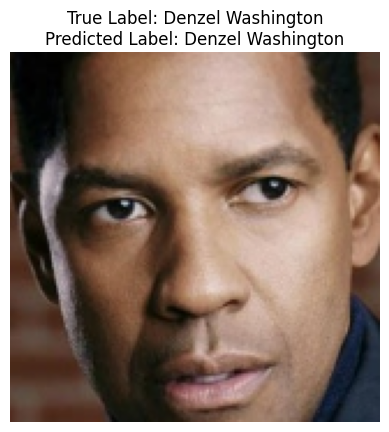

The true label for the image is: Denzel Washington
The predicted label for the image is: Denzel Washington


In [24]:
import matplotlib.pyplot as plt
# Path to the specific image
image_path = '/content/drive/MyDrive/Attendance/Cropped Faces/Denzel Washington/002_f44b8d45.jpg'


# Predict the label of the image
true_label, predicted_label, image = predict_cropped_image(image_path, model, label_encoder)

# Display the image
display_image(image, true_label, predicted_label)

print(f'The true label for the image is: {true_label}')
print(f'The predicted label for the image is: {predicted_label}')


In [25]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import pickle

In [26]:

# Load the custom fine-tuned model
model_path = '/content/drive/MyDrive/Attendance/fine_tuned_model.h5'
model = load_model(model_path)

# Function to capture photo using webcam in Colab
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        div.appendChild(video);
        document.body.appendChild(div);
        video.srcObject = stream;
        await video.play();

        // Resize the output to fit the video feed
        video.style.width = '100%';
        video.style.height = 'auto';

        // Wait for Capture button to be clicked
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getTracks().forEach(track => track.stop());
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename



In [28]:
# Load the trained model
model = load_model('/content/drive/MyDrive/Attendance/fine_tuned_model.h5')

In [29]:
# Define the face detection model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [30]:
# Preprocess image function
def preprocess_image(image, target_size=(160, 160)):
    image = cv2.resize(image, target_size)
    image = image.astype('float32') / 255.0
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image



In [31]:
# Face recognition function
def recognize_faces(face_image, model, label_encoder):
    face_image = preprocess_image(face_image)
    preds = model.predict(face_image)
    predicted_label_index = np.argmax(preds)
    predicted_label = label_encoder.inverse_transform([predicted_label_index])[0]
    prob = preds[0][predicted_label_index]
    return predicted_label, prob

In [32]:
import sqlite3

# Connect to (or create) the SQLite database
conn = sqlite3.connect('attendance.db')

# Create a cursor object
cursor = conn.cursor()

# Create an 'attendance' table
cursor.execute('''
CREATE TABLE IF NOT EXISTS attendance (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    student_id TEXT,
    student_name TEXT,
    date TEXT,
    status TEXT
)
''')

# Commit the changes and close the connection
conn.commit()
conn.close()


In [33]:
def handle_unknown_face(frame):
    # Optional: Save or log the image of unknown faces for later review
    cv2.imwrite('unknown_face.jpg', frame)


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 306ms/step
Recognized: Leonardo DiCaprio with probability 0.40


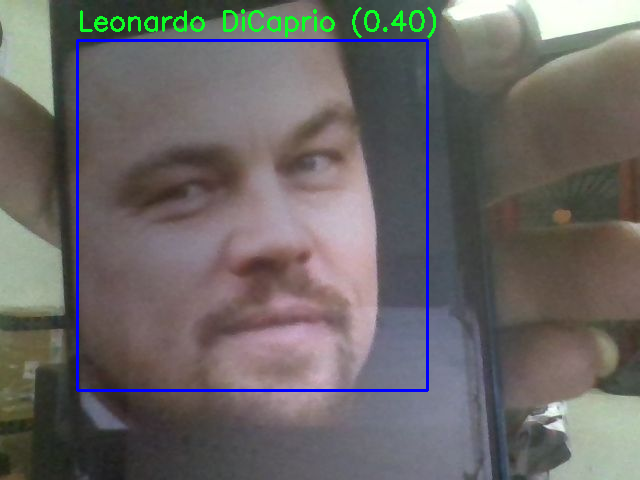

In [56]:
# Real-time recognition function
def run_real_time_system(model, label_encoder, face_cascade):
    photo_path = take_photo()
    img = cv2.imread(photo_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        face_image = img[y:y+h, x:x+w]
        predicted_label, prob = recognize_faces(face_image, model, label_encoder)

        if prob > 0.25:  # Confidence threshold
            print(f"Recognized: {predicted_label} with probability {prob:.2f}")
        else:
            print("Unknown face detected")

        # Draw rectangle around the face and put text
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(img, f"{predicted_label} ({prob:.2f})", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

    # Display the image with the detected face
    cv2_imshow(img)

# Run the system
run_real_time_system(model, label_encoder, face_cascade)


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 282ms/step
Unknown face detected


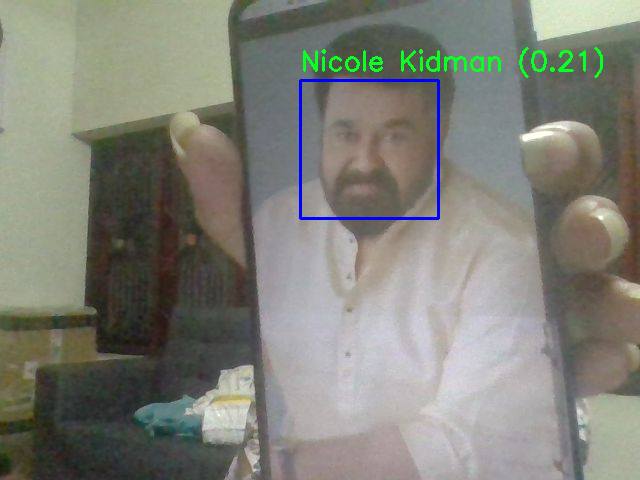

In [58]:
# Real-time recognition function
def run_real_time_system(model, label_encoder, face_cascade):
    photo_path = take_photo()
    img = cv2.imread(photo_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        face_image = img[y:y+h, x:x+w]
        predicted_label, prob = recognize_faces(face_image, model, label_encoder)

        if prob > 0.5:  # Confidence threshold
            print(f"Recognized: {predicted_label} with probability {prob:.2f}")
        else:
            print("Unknown face detected")

        # Draw rectangle around the face and put text
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(img, f"{predicted_label} ({prob:.2f})", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

    # Display the image with the detected face
    cv2_imshow(img)

# Run the system
run_real_time_system(model, label_encoder, face_cascade)